In [133]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import random
import math

In [174]:
# Classe do Model de Ising
class IsingModel:
    def __init__( self, L, T, J=1, H=0, Kb=1):
        # parametros do modelo
        self.L = L
        self.T = T
        self.J = J
        self.H = H
        self.Kb = Kb

        # array com os spins
        self.spins = np.ones( (L, L) )

        # arrays para guardar evolução das vari´aveis
        self.energies = []
        self.magnetizations = []

        self.nns = [(-1,0),(1,0),(0,-1),(0,1)]


    def calc_ener_spin( self, i, j ):
        # calcular a energia de um spin
        energy = 0
        s = self.spins[i,j]
        for (di,dj) in self.nns:
            s_n = self.spins[(i+di) % self.L, (j+dj) % self.L]
            energy += self.J * s * s_n 
        if self.H!=0:
            energy += self.h*s
        return energy

    def calc_ener( self ):
        # calcular a energia por spin do sistema
        # e = E / L^2
        total_energy = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                total_energy += self.calc_ener_spin(i, j)  
        energy = total_energy / (self.L**2)
        return energy

    def calc_energy_local( self, i, j):
        # compute local energy in neighborhood of (i,j) 
        energy_local = 0
        for (di,dj) in self.nns:
            energy_local += self.calc_ener_spin((i+di) % self.L, (j+dj) % self.L)
        return energy_local

    def calc_mag( self ):
        # calcular a magnetiza¸c~ao por spin do sistema
        # m = M / L^2
        total_mag = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                total_mag += self.spins[i,j]  
        mag = total_mag / (self.L**2)
        return mag

    def update_stats(self, energy, mag):
        self.energies.append(energy)
        self.magnetizations.append(mag)

    def boltzman_factor(self, energy):
        return math.exp(-energy/(self.Kb*self.T))
        
    def iter_monte_carlo( self, n_iter, progress=True):
        # iterar com o m´etodo de Metropolis Hastings
        #1.Escolher uma posiçãoo na rede aleatoriamente e trocar o valor do spin nessa posiçãoo, si ← −si
        #2. Calcular a diferen¸ca de energia ∆E entre a configuraçãoo anterior, X e a nova configuraçãoo, X
        #3. Aceitar a nova configuraçãoo caso ∆E < 0 ou e−∆E/kbT > u, sendo u um n´umero aleat´orio gerado a
        #partir de uma distribuiçãoo uniforme, u ∼ U [0, 1), isto ´e X ← X∗. Rejeitar caso contr´ario, mantendo a
        #configuraçãoo original. Aceitar significa alterar o valor do spin da posiçãoo escolhida, e atualizar o valor
        #da energia para a energia do novo sistema
        energy = self.calc_ener()
        mag = self.calc_mag()
        self.update_stats(energy, mag)
        total_energy = energy*(self.L**2)
        total_mag = mag*(self.L**2)
        mag = self.calc_mag()

        def _tqdm(tt, desc):
            if progress:
                return tqdm( tt, desc=desc)
            else:
                return tt
                
        for t in _tqdm( range(n_iter), desc=f"L={self.L:6d}, T={self.T:8f}" ):
            i,j = random.randint(0, self.L-1), random.randint(0, self.L-1)
            e = self.calc_energy_local(i, j)
            s = self.spins[i,j]
            s_ = -s #flip
            self.spins[i,j] = s_
            e_ = self.calc_energy_local(i, j)
            de = e_-e 
            accept = False
            if de<0:
                accept = True
            else:
                bf = self.boltzman_factor(de)
                if bf > random.random():
                    accept = True

            if not accept:
                self.spins[i,j] = s #revert
                continue
                
            total_energy += de 
            total_mag += 2*s_ 
            energy = total_energy/(self.L**2)
            mag = total_mag/(self.L**2)
            self.update_stats(energy, mag)
            

    @property
    def energy(self):
        # usa para aceder ao array com as energias
        return np.array(self.energies)

    @property
    def magnetization(self):
        # usa para aceder ao array com as magnetiza¸c~oes
        return np.array(self.magnetizations)

    def t_term_fit(self, N, t_term):
        e0, ef = self.energies[0], self.energies[-1]        
        return ef + (e0 - ef )*np.exp(-N/t_term) 
    
    def fit_t_termalization(self):
        def t_term_fit(N, t_term):
            return self.t_term_fit(N, t_term) 
        energy = self.energy
        xx = np.linspace(0,energy.shape[0], energy.shape[0])
        popt, pcov = curve_fit(t_term_fit, xx, energy)
        return popt[0]

        

In [127]:
def ising_plot_energy(ising, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Energy (L={ising.L}, T={ising.T:f})')
    ax.plot(ising.energy, label='<E>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_mag(ising, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Magnetization (L={ising.L}, T={ising.T:f})')
    ax.plot(ising.magnetization, label='<M>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_energy_fit(ising, ax):
    yfit = []
    energy = ising.energy
    xx = np.linspace(0,energy.shape[0], energy.shape[0])
    t_term = ising.fit_t_termalization()
    yfit = ising.t_term_fit(xx, t_term)         
    ax.plot(yfit, color='g', label='fit(<E>)')
    ax.legend()

def ising_plot_t_term(ising, ax):
    t_term = ising.fit_t_termalization()
    ymin, ymax = ax.get_ylim()
    ax.vlines(t_term, ymin=ymin, ymax=ymax, color='r', linestyles='--', lw=1)
    xpad = 4
    ax.text(t_term+xpad, ymin, f't_term={t_term:.4f}', color='r', fontsize=8)

def ising_plot_all(ising):
    nrows,ncols = 1,2
    fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
    ising_plot_energy(ising, axs[0])
    ising_plot_energy_fit(ising, axs[0])
    ising_plot_t_term(ising, axs[0])
    ising_plot_mag(ising, axs[1])
    ising_plot_t_term(ising, axs[1])
    plt.show()

    

L=    16, T=2.000000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 31205.53it/s]


t_term: 94.18767574049703


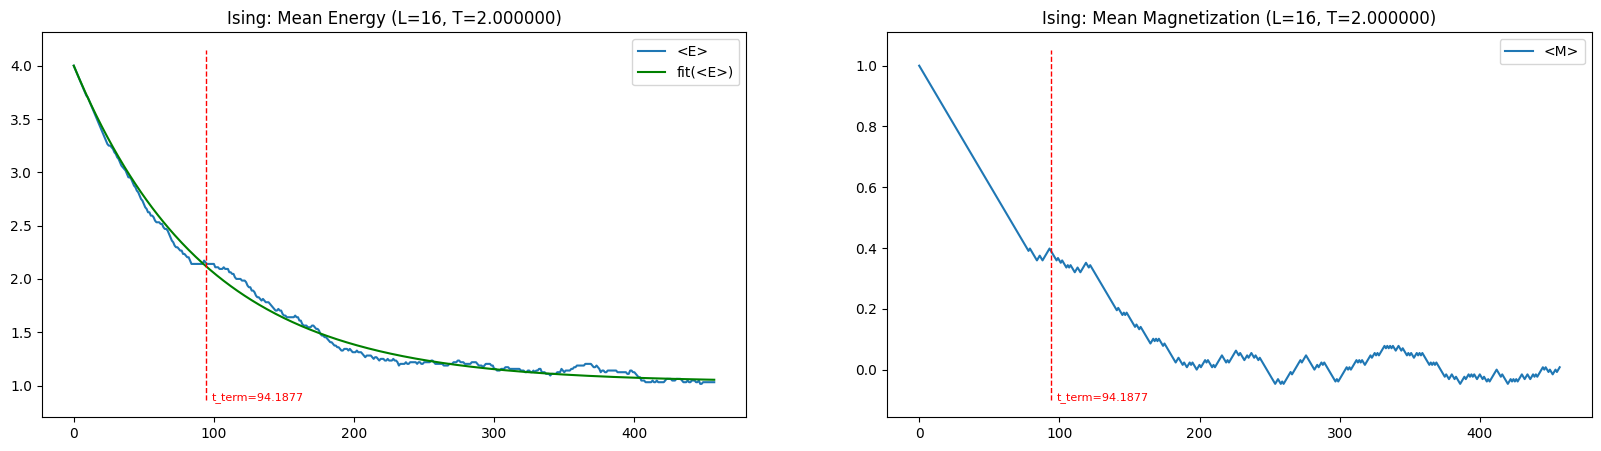

In [175]:
def test_ising(debug=False, plot=True):
    L = 16
    T = 2
    n_iter = 1000
    ising = IsingModel( L, T ) # criar um objecto da classe IsingModel
    ising.iter_monte_carlo( n_iter ) # correr o algoritmo de Metropolis-Hastings
    # aceder aos np.array que cont^em a energia e a magnetiza¸c~ao do sistema a cada itera¸c~ao MC
    energy = ising.energy
    magnetization = ising.magnetization
    t_term = ising.fit_t_termalization()
    print('t_term:', t_term)
    if debug:
        print('energy:', energy)
        print('magnetization:', magnetization)

    ising_plot_all(ising)
    
test_ising(debug=False)

In [129]:
def ising_run_experiments(n_iter = 100000):
    isings = {}
    for L in [16, 32, 64, 128]:
        for T in [1, 2, 3, 4]:
            ising = IsingModel( L, T )
            ising.iter_monte_carlo( n_iter )
            key = (L, T)
            isings[key] = ising
    return isings

def ising_plot_experiments(isings):
    for k, ((L,T),ising) in enumerate(isings.items()):
        ising_plot_all(ising)

isings = ising_run_experiments()


L=   128, T=4.000000: 100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34146.88it/s]


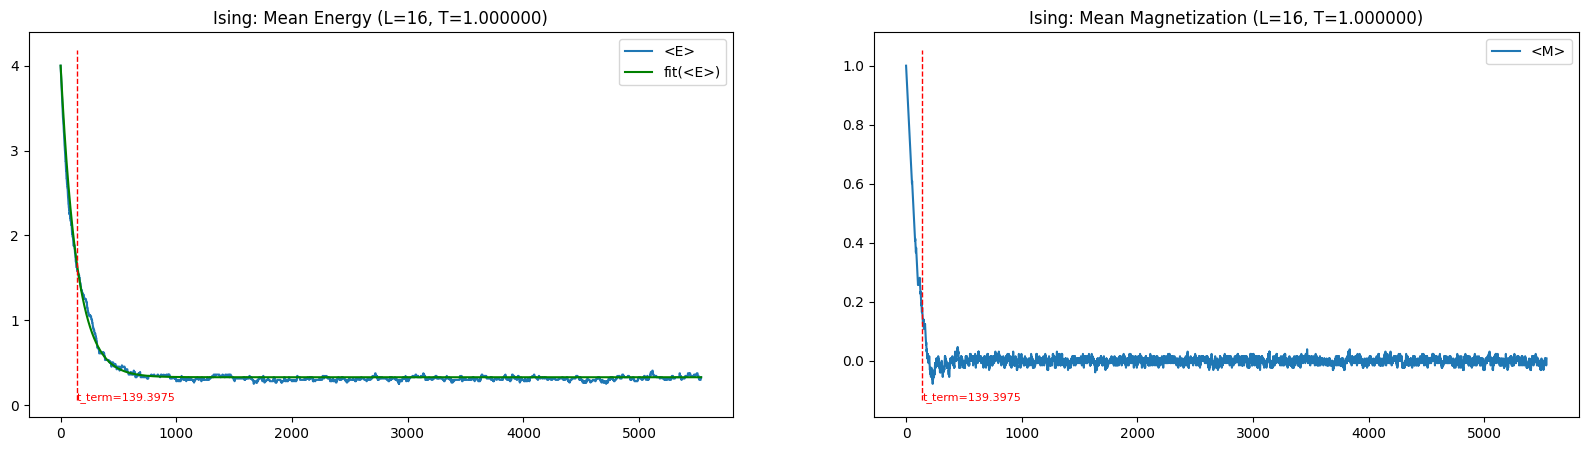

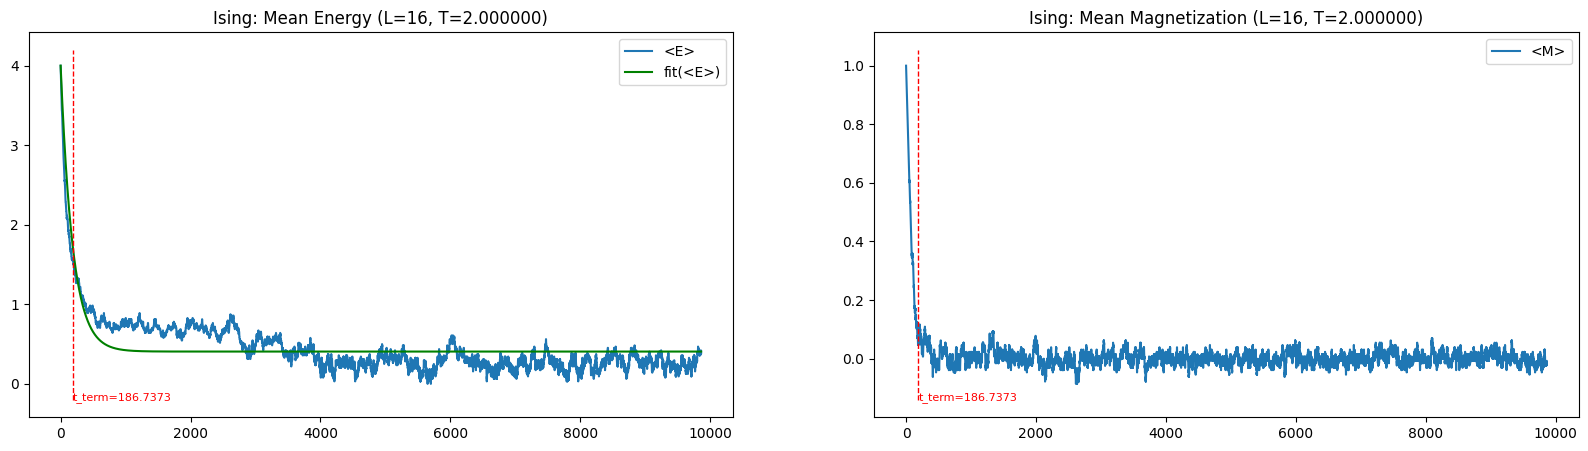

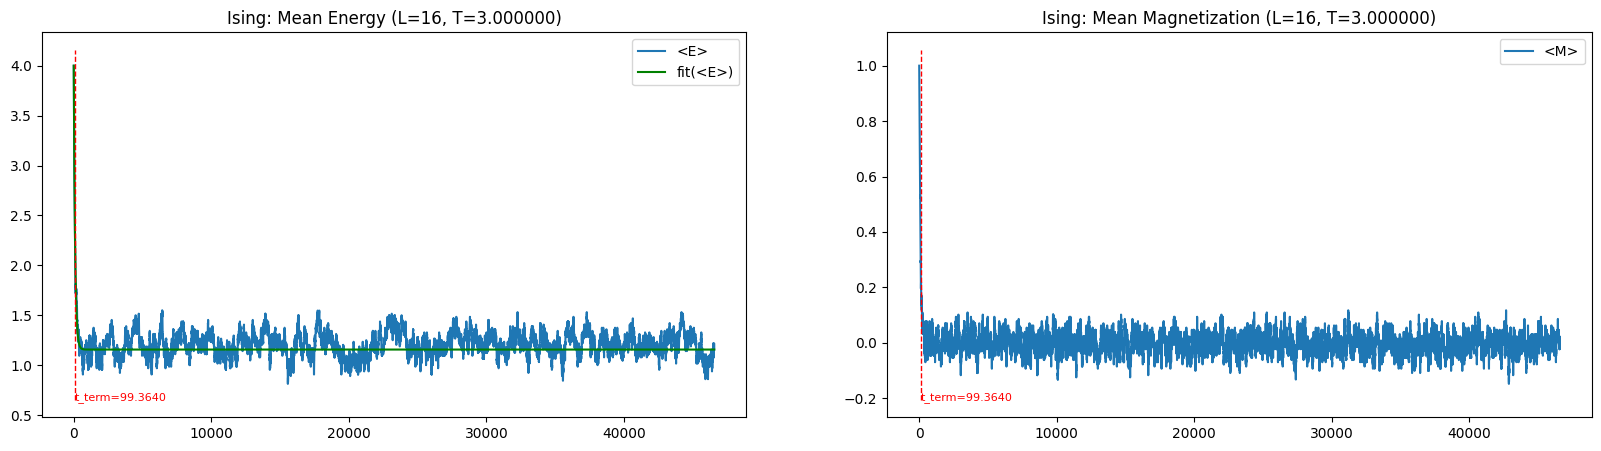

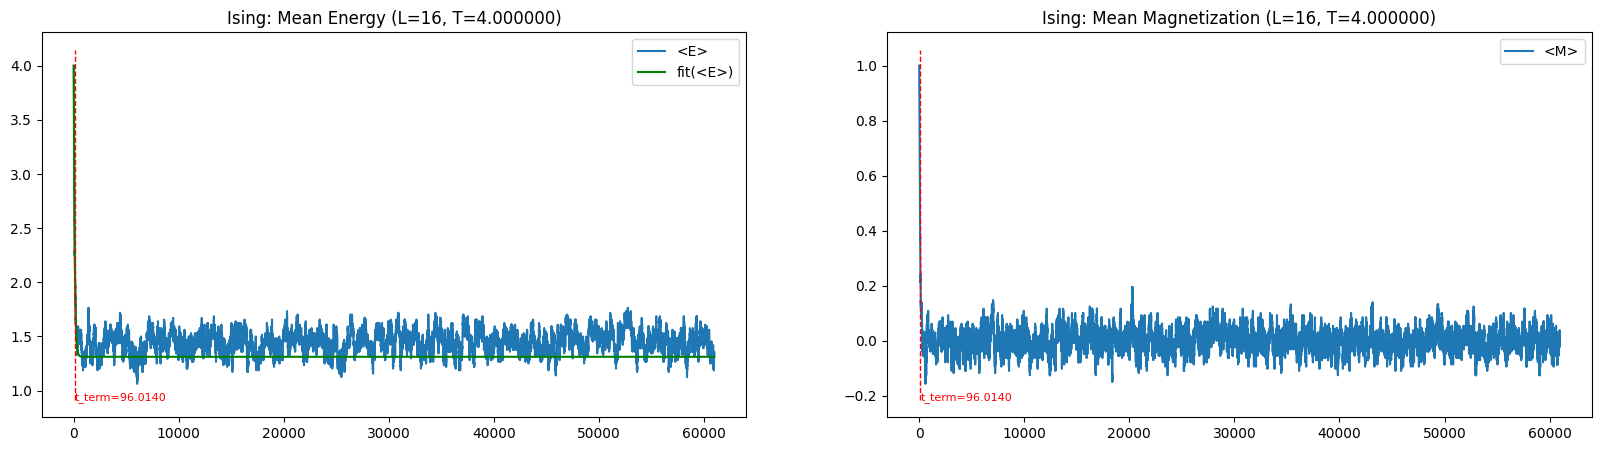

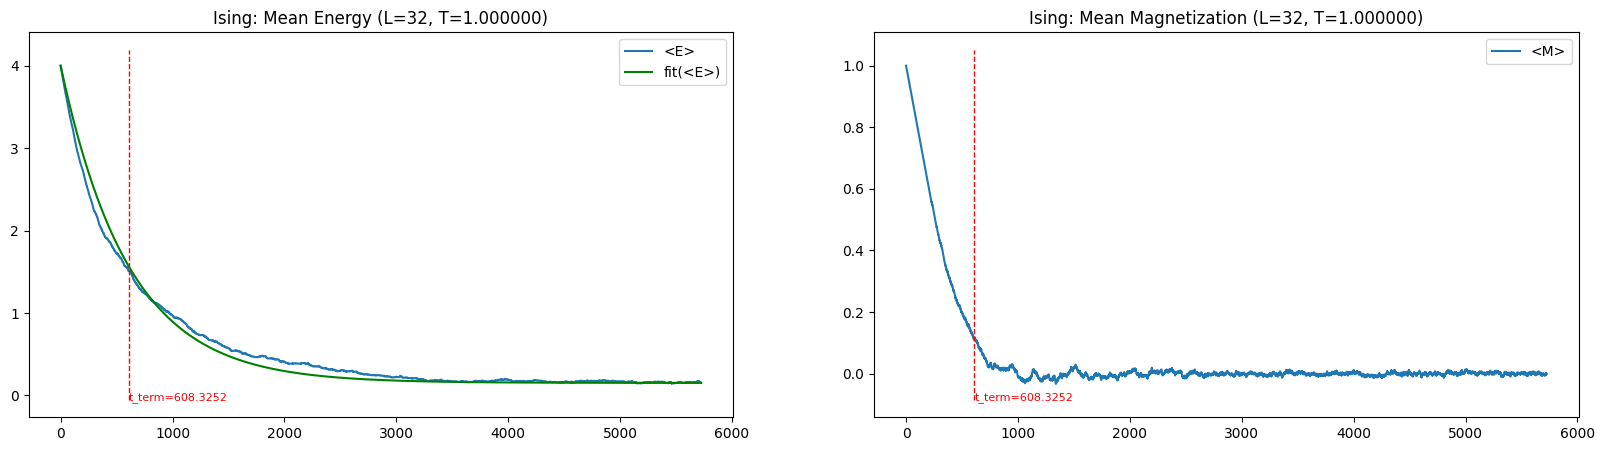

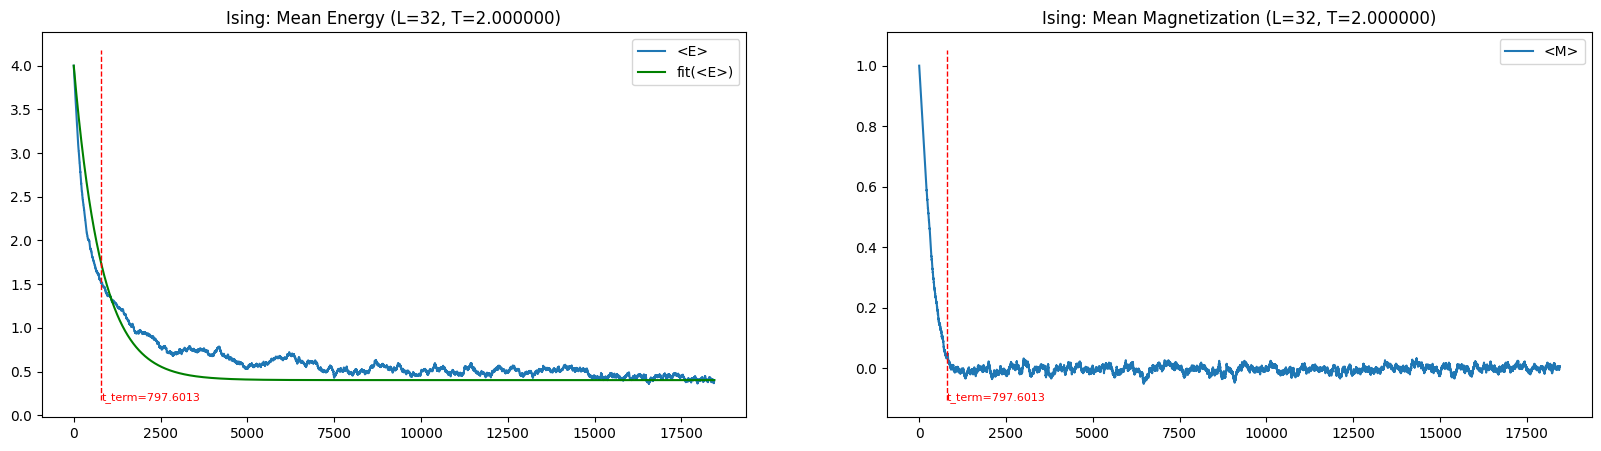

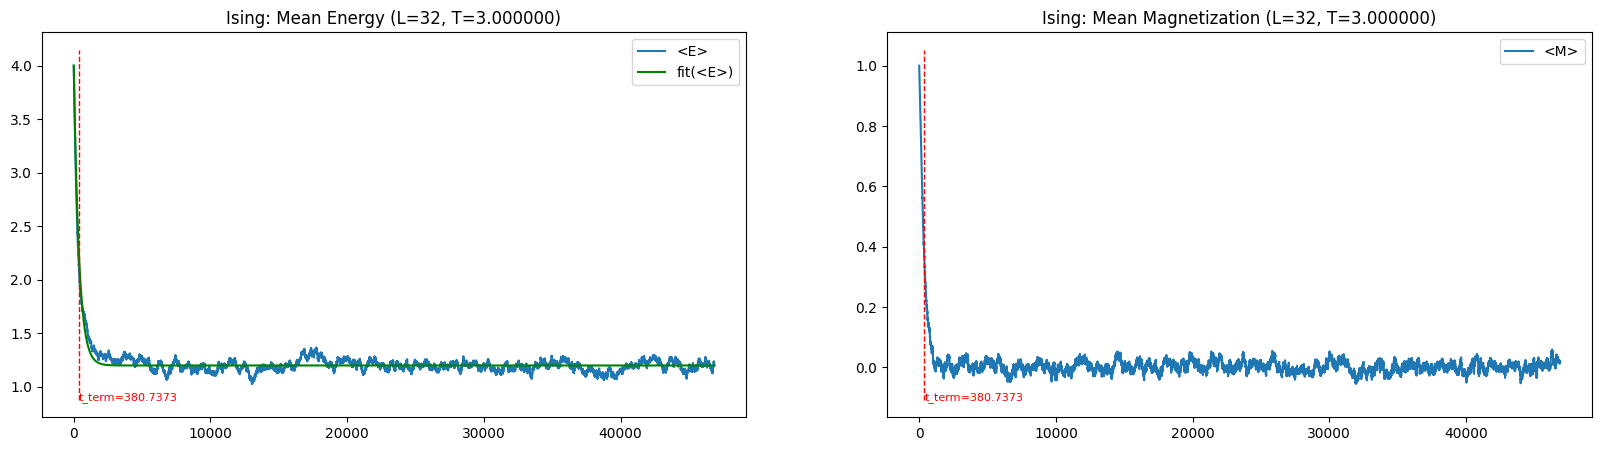

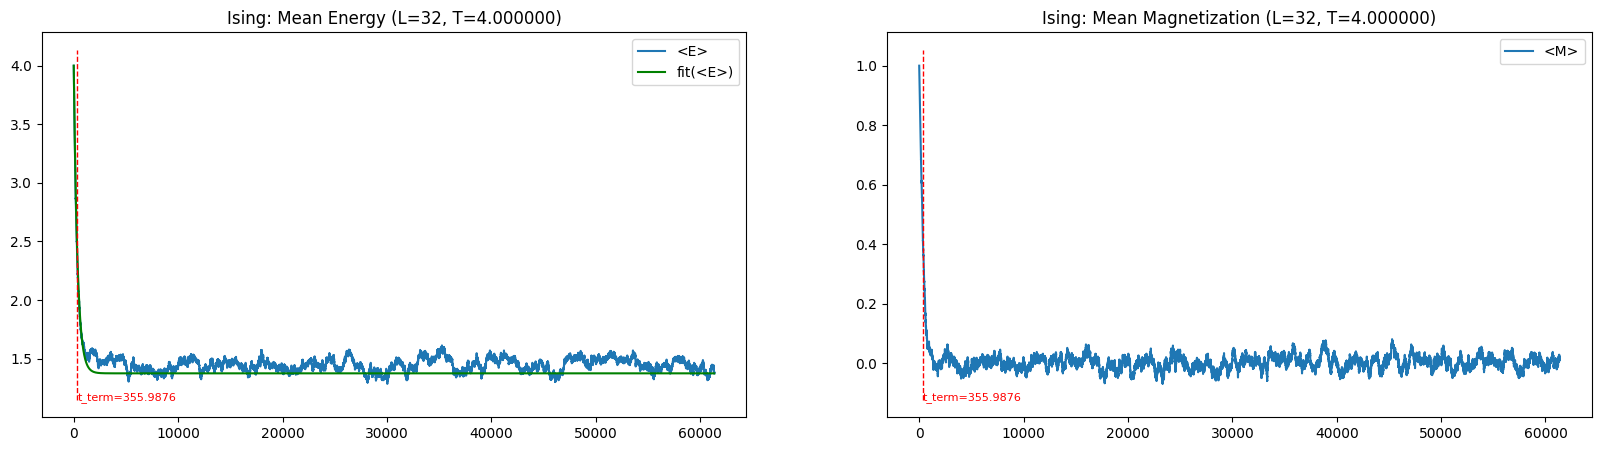

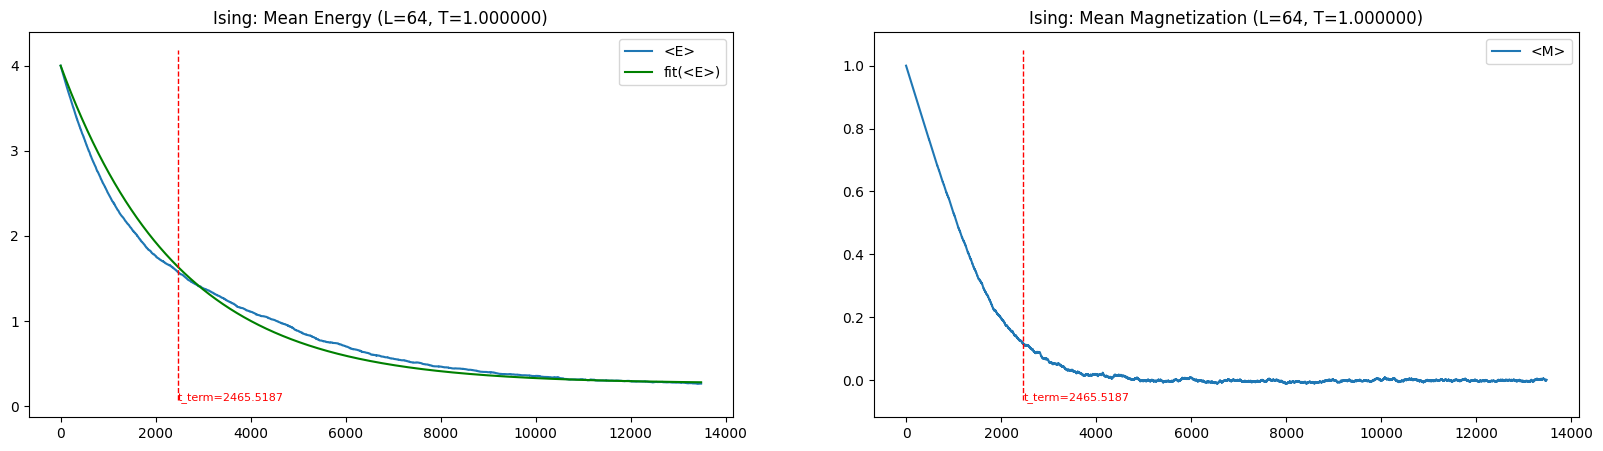

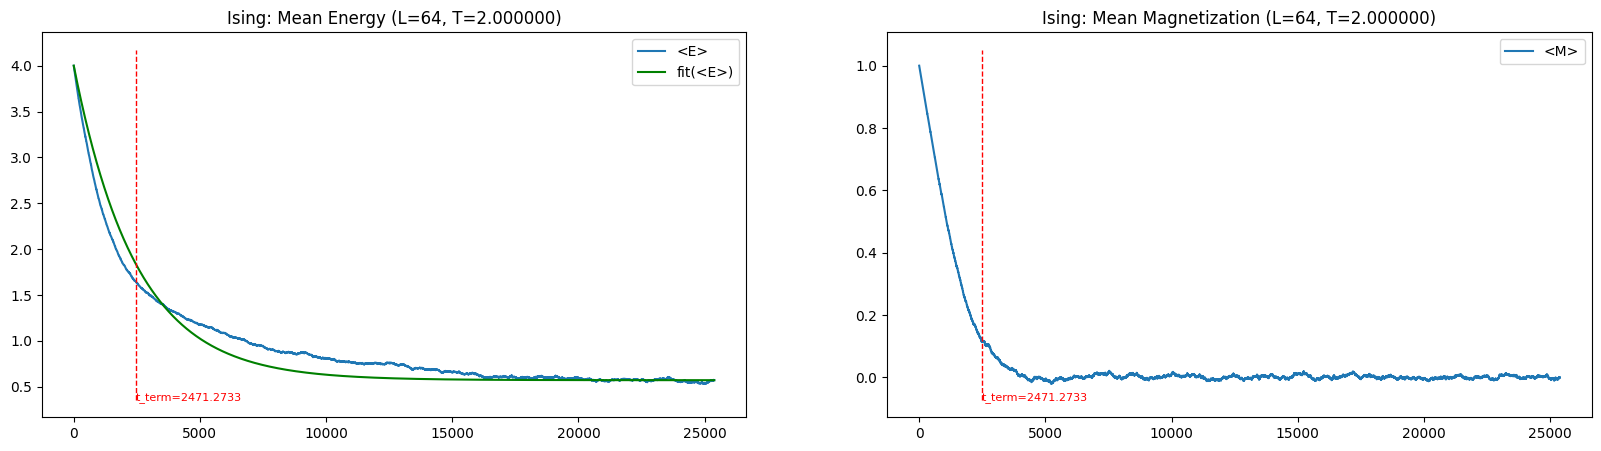

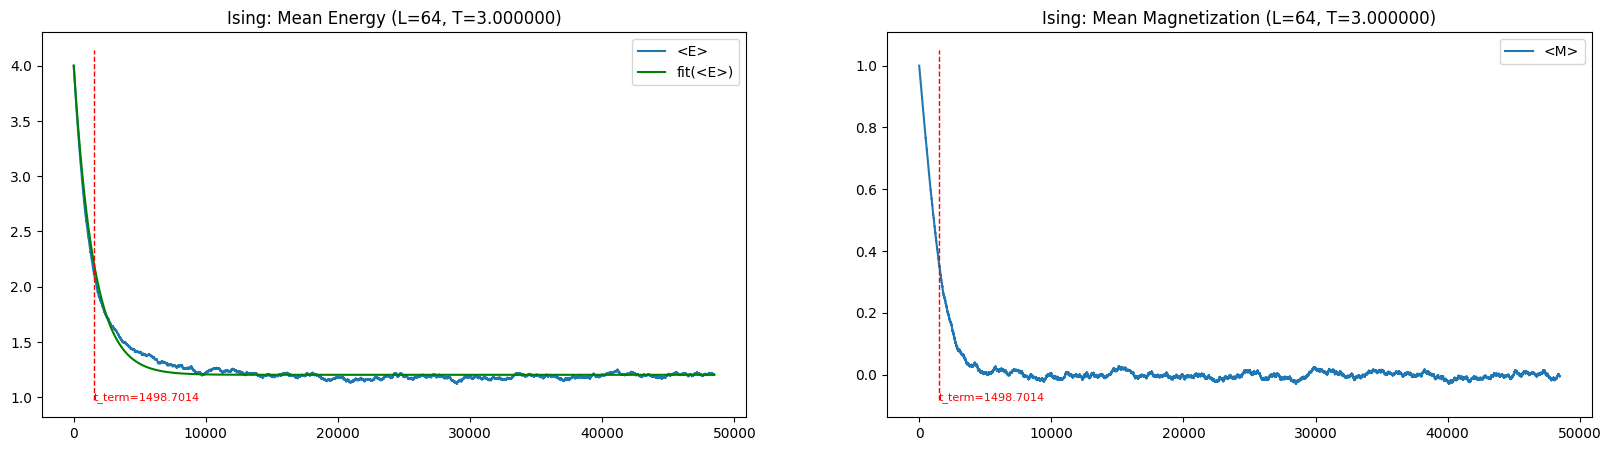

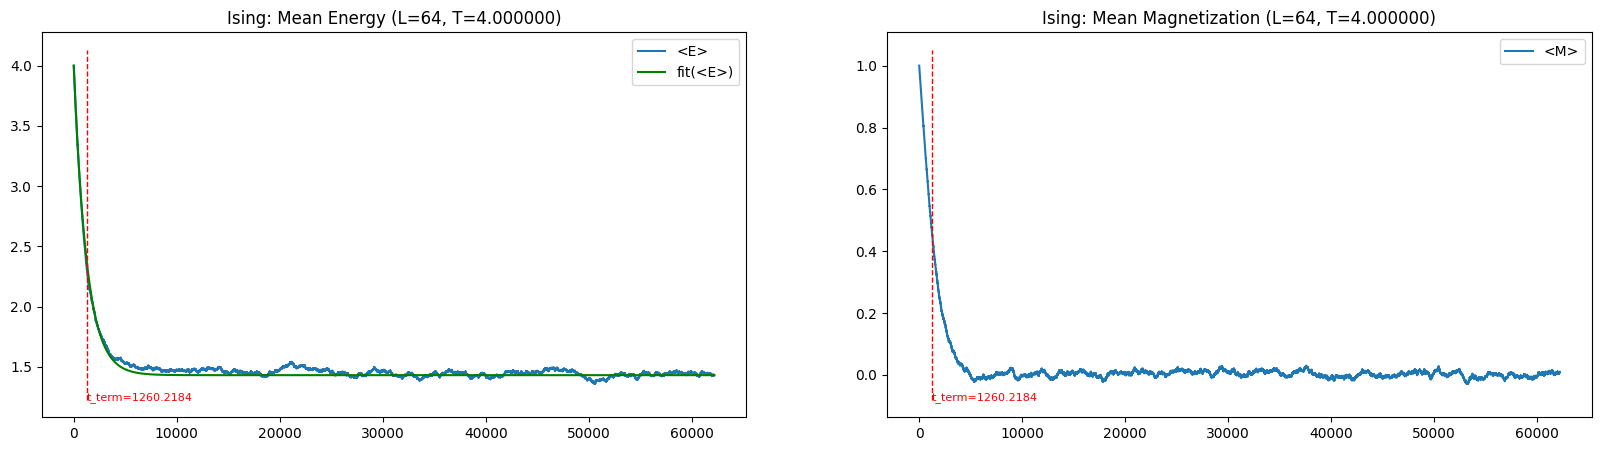

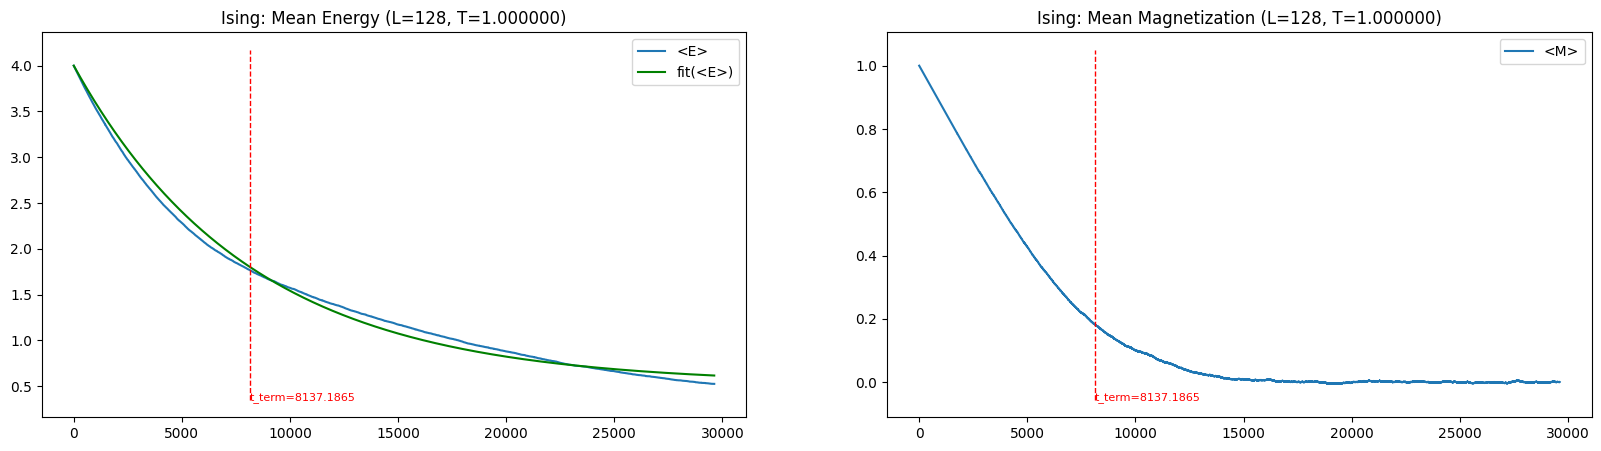

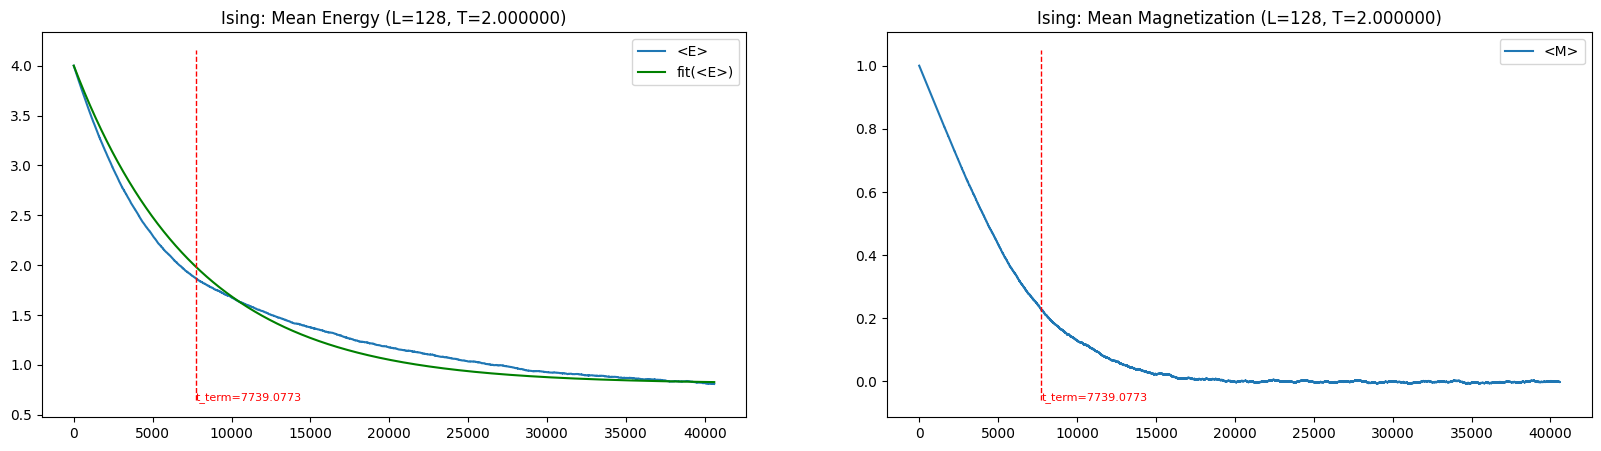

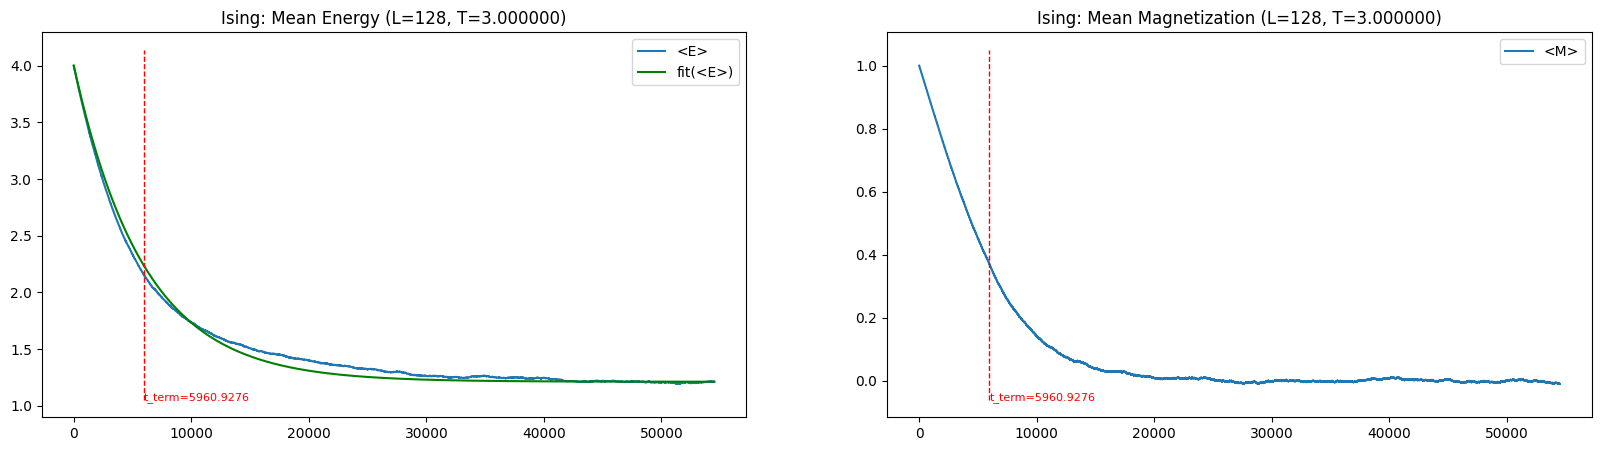

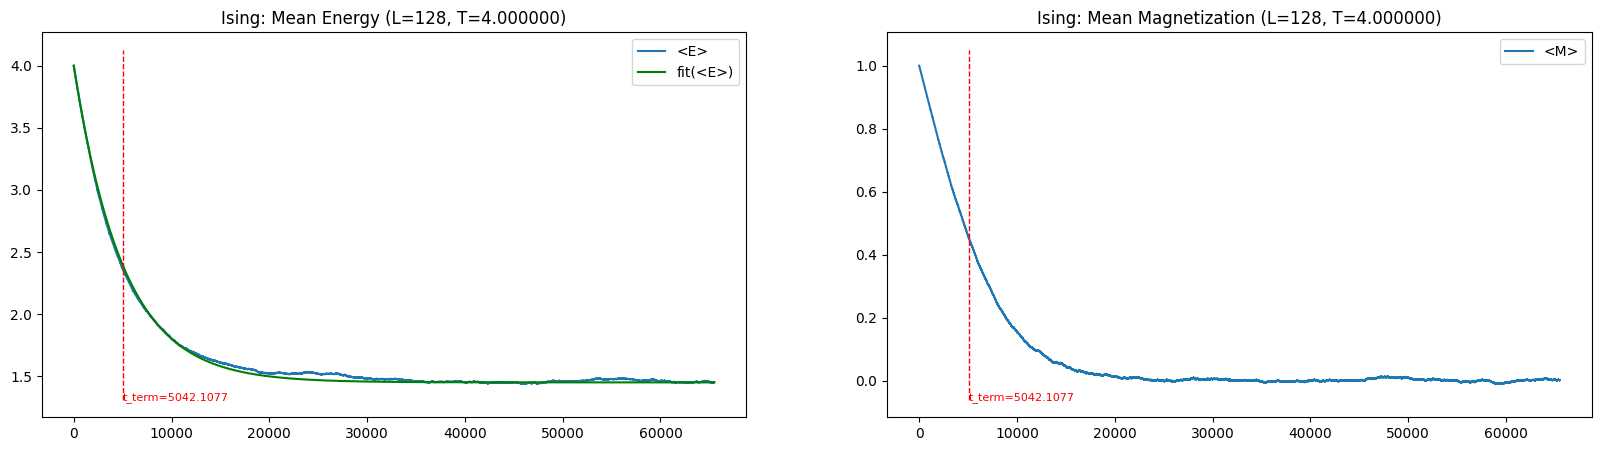

In [130]:
ising_plot_experiments(isings)

In [144]:
def ising_t_terms(n_iter = 100000):
    t_terms = []
    LL = [16, 32, 64, 128]
    TT = [1, 2, 3, 4]
    for i, L in enumerate(LL):
        t_terms.append([])
        for j, T in enumerate(TT):
            ising = IsingModel( L, T )
            ising.iter_monte_carlo( n_iter )
            t_term = ising.fit_t_termalization()
            t_terms[i].append(t_term)
    return t_terms,(LL,TT)

t_terms, t_term_params = ising_t_terms()
print(t_terms)
print(t_term_params)

L=   128, T=4.000000: 100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38290.47it/s]

[[217.6970017937248, 457.8915670497912, 79.13586744363062, 105.29366798642612], [706.600153379054, 818.4246525211748, 370.63452548397004, 345.09779902911197], [2339.051350428049, 2530.070616122855, 1614.4464909187593, 1232.3963507633207], [7987.430118026201, 7531.50252390449, 5831.459691178709, 5029.7013670537435]]
([16, 32, 64, 128], [1, 2, 3, 4])


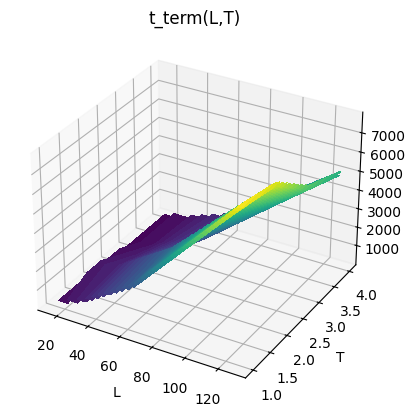

In [168]:
def plot_t_terms(t_terms, t_term_params, _type='wireframe'):
    LL,TT = t_term_params
    LL,TT = np.array(LL), np.array(TT)
    t_terms = np.array(t_terms)
    xg, yg = np.meshgrid(LL,TT, indexing='ij')
    interp = RegularGridInterpolator((LL, TT), t_terms, bounds_error=False, fill_value=None)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    #ax.scatter(xg.ravel(), yg.ravel(), t_terms.ravel(), s=60, c='k', label='t_term')
    #ax.plot_wireframe(xg, yg, interp, rstride=3, cstride=3, alpha=0.4, color='m', label='t_term')
    cax = ax.contourf(xg, yg, t_terms, levels=50, cmap='viridis')
    ax.set_title("t_term(L,T)")
    ax.set_xlabel("L")
    ax.set_ylabel("T")
    #fig.colorbar(cax, ax=ax)
    plt.show()


plot_t_terms(t_terms, t_term_params)


In [ ]:
def ising_LT(Tmin=1, Tmax=4, L=16, nrep = 1000000, n_iter = 100000):
    TT = np.linspace(Tmin,Tmax, int((Tmax-Tmin)/0.2))
    LL = [16, 32, 64, 128]
    stats = {}
    for L in LL:
        stats[L] = {'T': [], 'energy': [], 'energy_std': [], 'mag': [], 'mag_std': []}
        for T in TT:
            print(f'L: {L} ; T: {T:.4f}')
            energy_sum = 0
            mag_sum = 0
            energy2_sum = 0
            mag2_sum = 0
            for i in range(0, nrep):
                ising = IsingModel( L, T )
                n_iter = 10000
                ising.iter_monte_carlo( n_iter, progress=False)
                energy = ising.calc_ener()
                mag = ising.calc_mag()
                energy_sum += energy
                mag_sum += mag
                energy2_sum += energy**2
                mag2_sum += mag**2
            energy = energy_sum/nrep
            mag = mag_sum/nrep
            energy2 = energy2_sum/nrep
            mag2 = mag2_sum/nrep
            energy_std = math.sqrt(energy2 - energy**2)
            mag_std = math.sqrt(mag2 - mag**2)
            stats[L]['T'].append(T)
            stats[L]['energy'].append(energy)
            stats[L]['mag'].append(mag)
            stats[L]['energy_std'].append(energy_std)
            stats[L]['mag_std'].append(mag_std)
        print(f'L: {L} :', stats[L])
    return stats

stats_LT = ising_LT(nrep = 100)



L: 16 ; T: 1.0000
L: 16 ; T: 1.2143
L: 16 ; T: 1.4286
L: 16 ; T: 1.6429
L: 16 ; T: 1.8571
L: 16 ; T: 2.0714
L: 16 ; T: 2.2857
L: 16 ; T: 2.5000
L: 16 ; T: 2.7143
L: 16 ; T: 2.9286
L: 16 ; T: 3.1429
L: 16 ; T: 3.3571
L: 16 ; T: 3.5714
L: 16 ; T: 3.7857
L: 16 ; T: 4.0000
L: 16 : {'T': [1.0, 1.2142857142857142, 1.4285714285714286, 1.6428571428571428, 1.8571428571428572, 2.071428571428571, 2.2857142857142856, 2.5, 2.7142857142857144, 2.9285714285714284, 3.142857142857143, 3.357142857142857, 3.571428571428571, 3.7857142857142856, 4.0], 'energy': [-3.7325, -3.6884375, -3.5490625, -3.45625, -3.275, -2.9365625, -2.5940625, -2.2403125, -1.9559375, -1.6825, -1.505, -1.3790625, -1.30125, -1.1925, -1.1021875], 'energy_std': [0.2989016351577886, 0.2914958391105254, 0.33553406007252223, 0.3613667631368457, 0.36290386984709955, 0.40722131478932977, 0.3595378707017507, 0.3091917070665883, 0.26696701428968583, 0.2634180375372954, 0.2373650932635216, 0.19802023057947835, 0.18368621341842745, 0.202606067

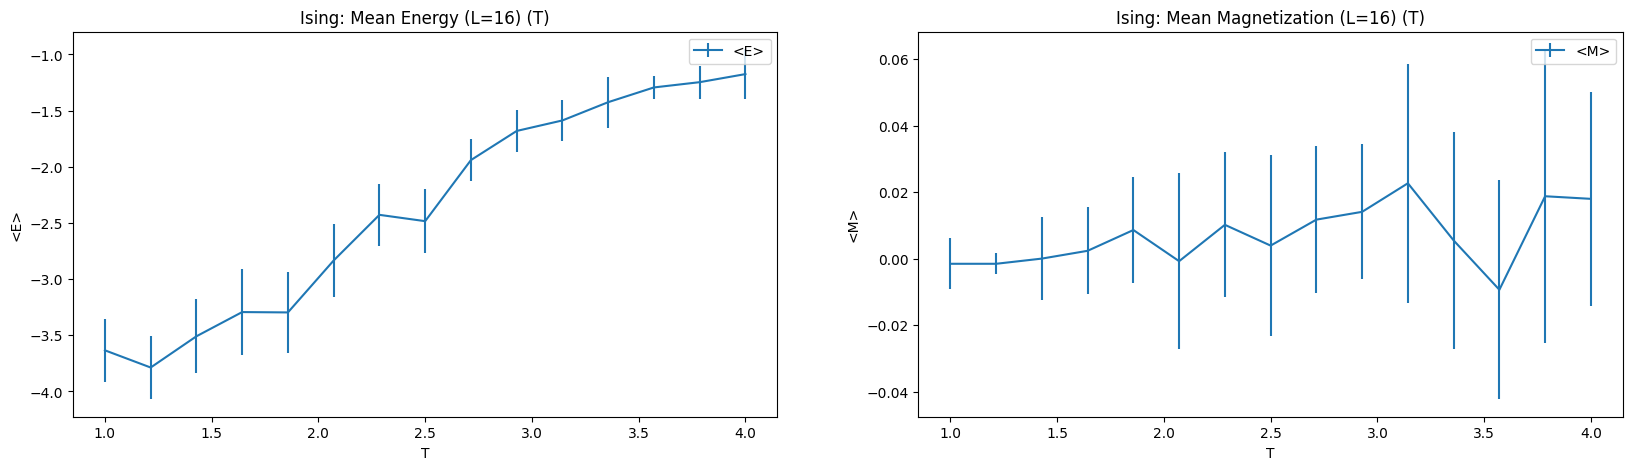

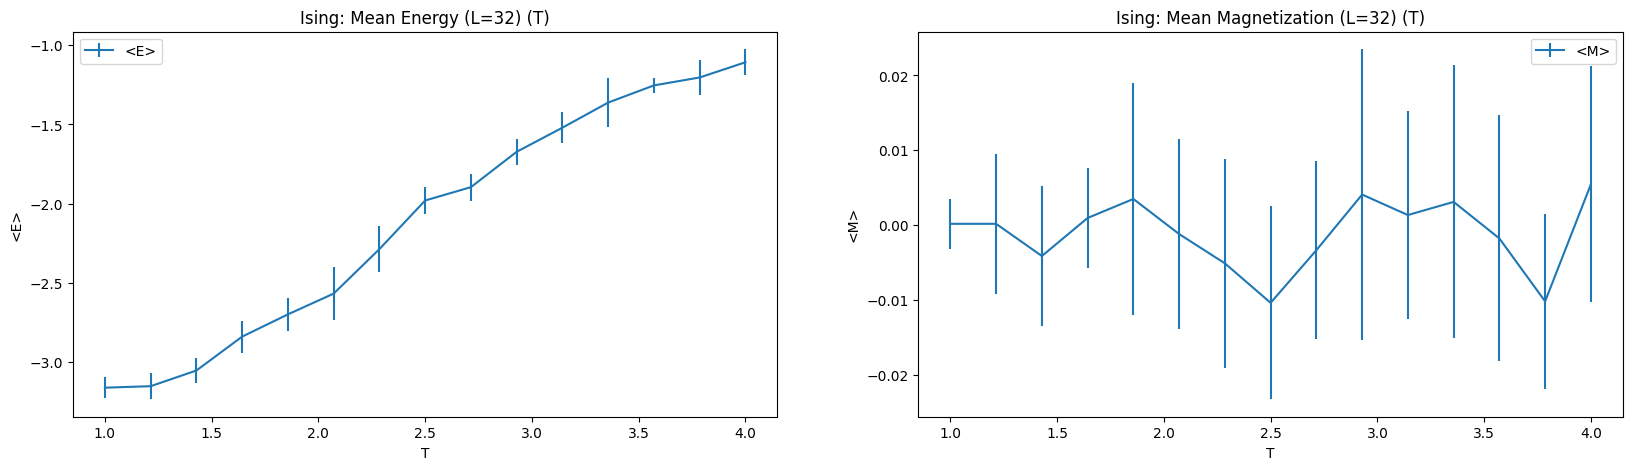

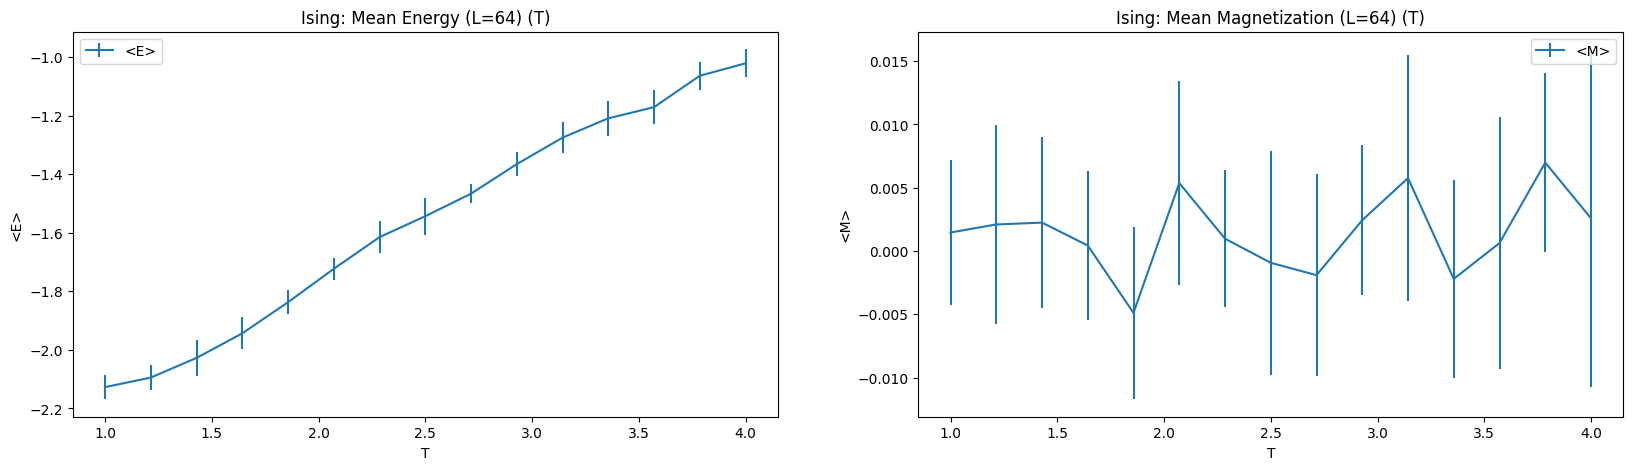

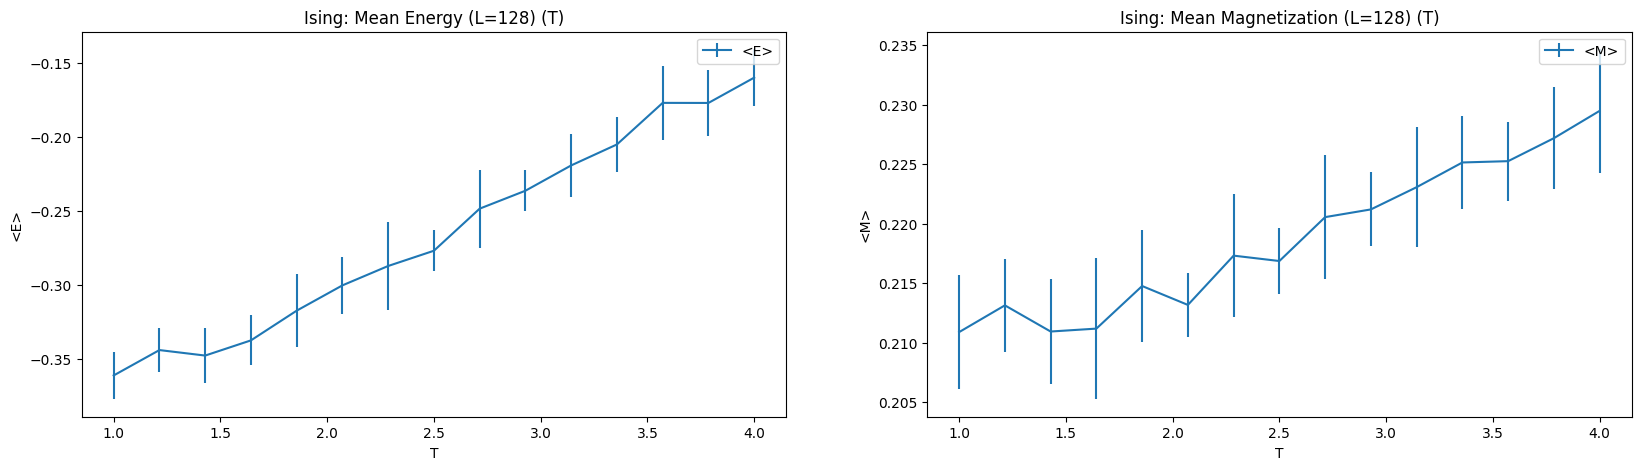

In [187]:
def ising_plot_energy_T(stats, L, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Energy (L={L}) (T)')
    ax.errorbar(stats['T'], stats['energy'], yerr=stats['energy_std'], label='<E>')
    ax.set_xlabel('T')
    ax.set_ylabel('<E>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_mag_T(stats, L, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Magnetization (L={L}) (T)')
    ax.errorbar(stats['T'], stats['mag'], yerr=stats['mag_std'], label='<M>')
    ax.set_xlabel('T')
    ax.set_ylabel('<M>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_T_all(stats, L):
    nrows,ncols = 1,2
    fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
    ising_plot_energy_T(stats, L, axs[0])
    ising_plot_mag_T(stats, L, axs[1])
    plt.show()

def ising_plot_L_T(stats_LT):
    for L,stats in stats_LT.items():
        ising_plot_T_all(stats, L)

ising_plot_L_T(stats_LT)